In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
from pandas.plotting import scatter_matrix
pd.set_option('display.max_columns', None)

import numpy as np
np.set_printoptions(linewidth=10000, precision=3)

from scipy.stats import loguniform
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    RandomizedSearchCV
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt

import mlflow
from mlflow import MlflowClient
import mlflow.sklearn
from datetime import datetime
import subprocess

mlflow.set_tracking_uri("https://mlflow-tracking-server-aysxrq6qeq-ts.a.run.app")

In [2]:
ENV = 'dev'

In [3]:
timestamp = datetime.now().strftime("%Y-%m-%d-%H:%M")
timestamp

'2025-08-12-16:53'

In [4]:
mlflow.set_experiment("nrl_winner_batch")

<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1754631411775, experiment_id='2', last_update_time=1754631411775, lifecycle_stage='active', name='nrl_winner_batch', tags={}>

In [5]:
mlflow.start_run(run_name=f'logreg_{timestamp}')
mlflow.autolog()

<ActiveRun: >

2025/08/12 16:53:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [6]:
commit_hash = subprocess.check_output(["git", "rev-parse", "HEAD"]).decode().strip()
mlflow.set_tag("git_commit", commit_hash)

In [7]:
df = pd.read_csv('train_df.csv')
df

,year,round_num,home_team,away_team,ladder_position_home,ladder_position_away,home_ladder_pos_diff,home_win
0,2010,24,Knights,Broncos,13,9,-4,1
1,2010,24,Cowboys,Bulldogs,16,14,-2,0
2,2010,25,Wests Tigers,Storm,3,5,2,1
3,2010,25,Roosters,Sea Eagles,7,6,-1,1
4,2010,25,Warriors,Broncos,8,9,1,1
...,...,...,...,...,...,...,...,...
5562,2015,1,Sharks,Raiders,0,0,0,0
5563,2017,1,Sharks,Broncos,0,0,0,0
5564,2019,1,Roosters,Rabbitohs,0,0,0,0
5565,2020,1,Raiders,Titans,0,0,0,1


In [8]:
df.isnull().sum()

year                    0
round_num               0
home_team               0
away_team               0
ladder_position_home    0
ladder_position_away    0
home_ladder_pos_diff    0
home_win                0
dtype: int64

In [9]:
df.home_win.mean()

np.float64(0.5726603197413328)

In [10]:
(df.year>=2025).sum()

np.int64(164)

In [11]:
df = df.sort_values(['year', 'round_num'])
X = df.drop(columns=['year', 'home_win'])
y = df.home_win

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=164, shuffle=False)

num_cols = X.select_dtypes(exclude='object').columns
cat_cols = X.select_dtypes(include='object').columns
num_cols, cat_cols

(Index(['round_num', 'ladder_position_home', 'ladder_position_away',
        'home_ladder_pos_diff'],
       dtype='object'),
 Index(['home_team', 'away_team'], dtype='object'))

In [12]:
tss = TimeSeriesSplit(n_splits=20)
splits = list(tss.split(X_train))[-6:]

In [13]:
for train_idx, test_idx in splits:
    print(
        df.iloc[train_idx].year.min(),
        df.iloc[train_idx].year.max(),
        df.iloc[test_idx].year.min(),
        df.iloc[test_idx].year.max(),
        len(train_idx),
        len(test_idx)
    )
    print('\n')

1998 2017 2017 2018 3861 257


1998 2018 2018 2019 4118 257


1998 2019 2019 2021 4375 257


1998 2021 2021 2022 4632 257


1998 2022 2022 2023 4889 257


1998 2023 2023 2024 5146 257




In [18]:
param_grid = {
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': loguniform(0.1, 100)
}

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols), # WRONG - it uses a different OHE for home and away team - combine it (but lose H/A info)?
])

pipe = Pipeline([
    ('preprocess', preprocess),
    ('logreg', LogisticRegression(solver='liblinear'))
])

cv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter=5,
    scoring='accuracy',
    cv=splits,
    refit=True,
    verbose=0,
    random_state=2025,
    n_jobs=1
)

In [19]:
cv.fit(X_train, y_train)

2025/08/12 16:56:03 WARNING mlflow.utils: Truncated the value of the key `cv`. Truncated value: `[(array([   0,    1,    2, ..., 3858, 3859, 3860], shape=(3861,)), array([3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3915, 3916, 3917, 3918, 3919, 3920, 3921, 3922, 3923, 3924, 3925, 3926, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3934, 3935, 3936, 3937, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3

,estimator,Pipeline(step...liblinear'))])
,param_distributions,"{'logreg__C': <scipy.stats....t 0x13f1fe270>, 'logreg__penalty': ['l1', 'l2']}"
,n_iter,5
,scoring,'accuracy'
,n_jobs,1
,refit,True
,cv,"[(array([ 0, ...shape=(3861,)), ...), (array([ 0, ...shape=(4118,)), ...), ...]"
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,2025
,error_score,nan


In [16]:
# cv.best_score_
# cv.best_params_

In [20]:
final_model = cv.best_estimator_

In [21]:
y_pred_test = final_model.predict(X_test)

In [22]:
test_accuracy = accuracy_score(y_test, y_pred_test)
print(test_accuracy)
mlflow.log_metric("test_accuracy", test_accuracy)

0.5914634146341463


In [23]:
run_id = mlflow.active_run().info.run_id
mlflow.end_run() # turn off autolog for next cell
mlflow.start_run(run_id=run_id)

🏃 View run logreg_2025-08-12-16:53 at: https://mlflow-tracking-server-aysxrq6qeq-ts.a.run.app/#/experiments/2/runs/97c3facec4c9417584fe180271a503ac
🧪 View experiment at: https://mlflow-tracking-server-aysxrq6qeq-ts.a.run.app/#/experiments/2


<ActiveRun: >

In [24]:
deploy_model = final_model.fit(X, y) 
info = mlflow.sklearn.log_model(
    deploy_model,
    artifact_path="deploy_model",
    registered_model_name="nrl_model_batch"
)
version = info.registered_model_version

client = MlflowClient()
client.set_model_version_tag("nrl_model_batch", version, "environment", ENV)
if ENV == 'dev':
    client.set_registered_model_alias("nrl_model_batch", "dev", version)
elif ENV == 'prod':
    client.set_registered_model_alias("nrl_model_batch", "staging", version)
    # check if promote to prod...

2025/08/12 17:01:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/alex/Library/Caches/pypoetry/virtualenvs/nrl-predictor-ueoDKUfV-py3.12/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/08/12 17:01:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a w

MlflowException: API request to endpoint /api/2.0/mlflow/logged-models failed with error code 404 != 200. Response body: '<!doctype html>
<html lang=en>
<title>404 Not Found</title>
<h1>Not Found</h1>
<p>The requested URL was not found on the server. If you entered the URL manually please check your spelling and try again.</p>
'

# Additional eval - WIP

In [ ]:
y_pred_proba_test = final_model.predict_proba(X_test)

<Axes: >

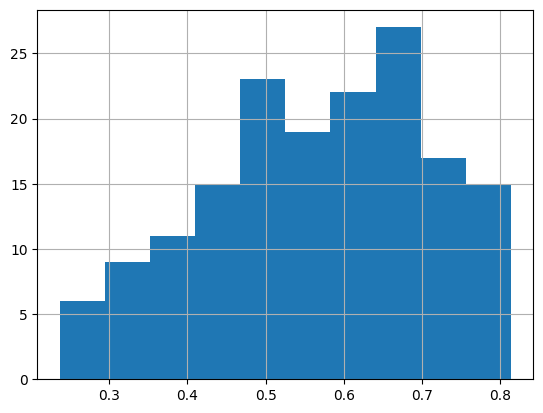

In [133]:
pd.Series(y_pred_proba_test[:,1]).hist()

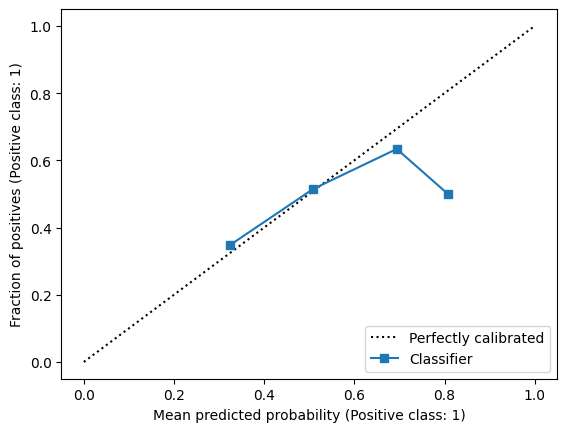

In [134]:
from sklearn.calibration import CalibrationDisplay
CalibrationDisplay.from_predictions(y_test, y_pred_proba_test[:,1])

In [135]:
test['pred'] = y_pred_test
test['pred_proba'] = y_pred_proba_test[:,1]
test

,year,round_num,home_team,away_team,ladder_position_home,ladder_position_away,home_ladder_pos_diff,home_win,pred,pred_proba
5365,2025,1,Panthers,Sharks,0,0,0,1,1,0.584553
5402,2025,1,Storm,Eels,0,0,0,1,1,0.677112
5435,2025,1,Dragons,Bulldogs,0,0,0,0,1,0.509573
5480,2025,1,Raiders,Warriors,0,0,0,1,1,0.620921
5481,2025,1,Rabbitohs,Dolphins,0,0,0,1,1,0.565142
...,...,...,...,...,...,...,...,...,...,...
4054,2025,22,Sea Eagles,Roosters,9,10,1,0,1,0.586532
4055,2025,22,Dragons,Raiders,12,1,-11,1,0,0.427832
4056,2025,22,Wests Tigers,Bulldogs,13,2,-11,1,0,0.281714
4057,2025,22,Eels,Storm,14,3,-11,0,0,0.361091


In [136]:
test.groupby('year').pred_proba.mean()
test.groupby('round_num').pred_proba.mean()

year
2025    0.56667
Name: pred_proba, dtype: float64

round_num
1     0.585361
2     0.546594
3     0.526011
4     0.489062
5     0.619379
6     0.599837
7     0.516311
8     0.601142
9     0.555317
10    0.580635
11    0.582148
12    0.598605
13    0.534003
14    0.619425
15    0.479531
16    0.555389
17    0.577475
18    0.629216
19    0.459112
20    0.644513
21    0.641834
22    0.509667
Name: pred_proba, dtype: float64

In [19]:
test.groupby('round_num').apply(lambda x: accuracy_score(x.home_win, x.pred)).plot()

/var/folders/f0/lg0qyy8n1gg_khp86kzryb8h0000gn/T/ipykernel_61713/2260686862.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test.groupby('round_num').apply(lambda x: accuracy_score(x.home_win, x.pred)).plot()


<Axes: xlabel='round_num', ylabel='Fraction of positives (Positive class: 1)'>